https://github.com/aylliote/senti-py

## Cargar librerias

In [0]:
!pip install -q spanish-sentiment-analysis
!pip install -q twilio
!pip install -q googletrans

In [0]:
# directorio=["Julio Velarde Flores (Presidente del Directorio)","Luis Miguel Palomino Bonilla (Vicepresidente)", "José Chlimper Ackerman", "Elmer Cuba Bustinza", "Javier Escobal D’Angelo", "Rafael Rey Rey", "Gustavo Yamada Fukusaki"]
# politico=["@PepeChlimper","@reyreysincorona","@jvelarde2908"]
 ##https://materializecss.com/color.html
#EfeméridesBCRP
#BCRP

In [5]:
import tweepy #Importamos el paquete para consumir el API de Twitter
import pandas as pd #Manejar dataframes para almacenamiento y procesamiento de datos
import re #Realizar el proceso de limpieza de textos, con expresiones regulares
import unicodedata #Para manejar los caracteres especiales de un idioma en especifico.
from classifier import * #Utilizar un modelo de sentimiento pre-entrenado en español
from twilio.rest import Client #Utilizar API de whatsapp para enviar las alertas de tweets negativos por mensajes
import datetime #Para configurar la zona horaria
from googletrans import Translator #Utilizar API para realizar la traducción 
import nltk #Provee herramientas de procesamiento de lenguaje natural (NTL)
from nltk.corpus import stopwords #Importamos el método para el analisis de palabras irrelevantes
nltk.download('stopwords') #Descargamos la lista de palabras que no agregan valor al momento del análisis
from nltk.sentiment.vader import SentimentIntensityAnalyzer #Importamos la clase de análisis de sentimiento en inglés
nltk.download('vader_lexicon') #Descargamos el corpus del modelo de análisis de sentimiento en inglés
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


### Ingresar las credenciales de twitter

In [0]:
#Ingresas las credenciales brindadas por twitter: 
#1° Se crea la cuenta desarrollador: #https://www.extly.com/docs/autotweetng_joocial/tutorials/how-to-auto-post-from-joomla-to-twitter/apply-for-a-twitter-developer-account/#apply-for-a-developer-account 
#2° Se crea las claves para comunicarnos con la api: https://developer.twitter.com/en/apps
#Claves de cuenta desarrollador
consumer_key = 'SE2j5h44iblufyn0g7nK1yxB7'
consumer_secret = 'AyCZwDYdJlichj9KdOAs7KXWKXv0VtsRUicVdlOoTWu9SKiLHC'
#Claves para comunicarnos con la API
access_token = '1045877872370626561-GeMexqKDTK3TdCjxczBakXyeg0SU7X'
access_token_secret = 'Yk3YNNoeNeVzhVevkSusToKeL8om9jVWEpNonWA5nKma6'

### Scrapear los contenidos de twitter

In [0]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret) #Seteando claves de la cuenta de desarrollador
auth.set_access_token(access_token, access_token_secret) #Seteando claves para comunicarnos con la API
api = tweepy.API(auth,wait_on_rate_limit=True) #llamando al API de twitter pasando como parámetro la autenticación y poniendo el limite de velocidad en automático
listOfTweets = [] #crea una lista vacía para almacenar los tweets
hour_per = datetime.timezone(datetime.timedelta(hours=-5))#Configurar la zona horaria 

for tweet in tweepy.Cursor(api.search #utilizar el servicio de búsqueda del cursor
                           ,q = "@bcrpoficial" #definir la palabra clave a buscar
                           ,tweet_mode="extended", #Para que salga completo el texto del tweet
                           lang="es", #idioma español
                           since="2019-12-08", #define a partir de qué fecha se extraerá  
                           ).items(2000):#sólo los 2000 mas recientes según la fecha escrita
    
    if tweet.user.followers_count >=1000:#Filtrando cuentas que tengan mas de 1000 seguidores
        dict_ = {'V_NOMBRE': tweet.user.screen_name,#Alias/Nombre
                'V_USUARIO': tweet.user.id,#id de usuario en tweeter
                'I_NRO_SEGUIDORES': tweet.user.followers_count,  #Nro de seguidores
                'V_FECHA': tweet.created_at.astimezone(hour_per),#Hora de Creación del tweet
                'V_TEXTO': tweet.full_text,#Texto
                'V_LOCALIZACION': tweet.user.location,#Localización donde se realizó el tweet
                'V_COORDENADAS': tweet.coordinates,#Coordenadas
                'I_NRO_RETWEETS': tweet.retweet_count, #Nro de Retweets que tiene dicho tweet
                'V_TIPO_TELEFONO': tweet.source #Dispositivo/Origen del tweet (Android, Iphone, Web, etc)
                }
        listOfTweets.append(dict_) #se agregan los elementos a la lista

##Almacenando los datos en un DataFrame

In [8]:
data=pd.DataFrame(listOfTweets) #Almacenando la lista de diccionarios en un dataframe
data["I_PERIODO_ID"]=[str(i)[0:10].replace("-","") for i in data["V_FECHA"]] #Adaptacion de periodo a numérico
data["V_LINKS"]=[" , ".join(re.findall('http\S+',i)) if len(re.findall('http\S+',i))>0 else "no hay links" for i in data["V_TEXTO"]] #Extracción de links del textos en los tweets
print(data.shape)#dimensión del dataframe antes de eliminación de retweets
data.head() #visualización de dataframe

(215, 11)


,V_NOMBRE,V_USUARIO,I_NRO_SEGUIDORES,V_FECHA,V_TEXTO,V_LOCALIZACION,V_COORDENADAS,I_NRO_RETWEETS,V_TIPO_TELEFONO,I_PERIODO_ID,V_LINKS
0,alanele,5441382,4964,2020-04-02 22:14:43-05:00,"RT @vozdelatierra: Lo que es inteligente, en s...",Perú,None,4,Twitter for Android,20200402,no hay links
1,RafaelRomeroVas,169299339,3492,2020-04-02 22:09:58-05:00,RT @Otrosidigo: @noticiAmerica Julio Velarde d...,"Lima, Perú",None,1,Twitter for Android,20200402,no hay links
2,vozdelatierra,361042982,64412,2020-04-02 22:06:54-05:00,"Lo que es inteligente, en sulógica, es que hay...",,None,4,Twitter for iPhone,20200402,https://t.co/DxjvR3fzNw
3,abelgilvonio,1553989603,7145,2020-04-02 22:03:02-05:00,@reyreysincorona Los peruanos tambien queremos...,"Lima, Peru",None,0,Twitter for Android,20200402,no hay links
4,ApacheDHC,1353264535,1814,2020-04-02 22:02:08-05:00,RT @JoseLuisGil1000: A Mr. Julio Velarde jefe ...,Lima - Perú,None,119,Twitter for Android,20200402,no hay links


### Eliminar los re-tweets

In [9]:
data=data[data["V_TEXTO"].str[0:3]!="RT "] #Eliminar Retweets
print(data.shape)#dimensión del dataframe después de eliminación
data.head()#visualizando

(93, 11)


,V_NOMBRE,V_USUARIO,I_NRO_SEGUIDORES,V_FECHA,V_TEXTO,V_LOCALIZACION,V_COORDENADAS,I_NRO_RETWEETS,V_TIPO_TELEFONO,I_PERIODO_ID,V_LINKS
2,vozdelatierra,361042982,64412,2020-04-02 22:06:54-05:00,"Lo que es inteligente, en sulógica, es que hay...",,None,4,Twitter for iPhone,20200402,https://t.co/DxjvR3fzNw
3,abelgilvonio,1553989603,7145,2020-04-02 22:03:02-05:00,@reyreysincorona Los peruanos tambien queremos...,"Lima, Peru",None,0,Twitter for Android,20200402,no hay links
6,mico_viejo,909825961620893696,1513,2020-04-02 20:44:56-05:00,"Julio Velarde, déjame decirte que eres un mise...",,None,4,Twitter for Android,20200402,no hay links
7,jpmorgan_ni,399712421,1227,2020-04-02 20:42:55-05:00,@JulianaOxenford éste es el gesto populista(su...,Peru,None,0,Twitter for Android,20200402,https://t.co/hlnrydizAB
8,abelgilvonio,1553989603,7145,2020-04-02 20:42:38-05:00,Velarde del @bcrpoficial está preocupado por g...,"Lima, Peru",None,9,Twitter Web App,20200402,no hay links


### Limpieza del Texto

In [0]:
def remove(words): #crea una función para utilizarla posteriormente
    clean_words = [] #crea una lista nueva
    for word in words: ## recorrer por cada tweet    
        sin_saltos=re.sub('\n', ' ', word.lower()) ###  convertir a minuscula
        sin_url=re.sub(r'http\S+', '',sin_saltos)### remover las urls
        sin_nickname=re.sub(r'@\S+', '', sin_url) ### remover los screen_name 
        sin_hashtag=re.sub(r'#\S+', '', sin_nickname)### remover los hashtag 
        sin_character = re.sub(r'[^\w\s]', '',sin_hashtag) ##remover los signos de puntuacion y/o características especiales
        sin_numero = re.sub("\d+", "", sin_character)## remover los numeros
        sin_tildes = sin_numero.translate(str.maketrans('áéíóúü','aeiouu'))
        # sin_tildes = unicodedata.normalize("NFKD",str(sin_numero)).encode("ascii","ignore").decode("ascii")##elimina tildes y reemplazar la ñ por la n 
        clean_words.append(sin_tildes.strip()) ##eliminar los espacios en los textos al comienzo y al final y lo almacenamos en una lista   
    return clean_words

### Remover Stopwords

In [0]:
Stopwords=stopwords.words("spanish") ### obtener la lista de stopwords en idioma español
Stopwords=[unicodedata.normalize("NFKD",str(i)).encode("ascii","ignore").decode("ascii") for i in Stopwords]
def remove_stopwords(news): ### crear la función para eliminar los stop_words
    sin_stopwords=[] ### crear una lista para almacenar comentarios sin stopwords
    for new in news: ### recorrer por cada tweet
        content=[word for word in new.split() if word not in Stopwords] ### almacenar palabras que no sean stopwords
        sin_stopwords.append(" ".join(content)) #juntamos dichas palabras en un parráfo
    return sin_stopwords #retornamos lista

In [12]:
data["V_TEXTO_LIMPIO"]=remove(data["V_TEXTO"]) #Limpiamos utilizando la función creada anteriormente y guardamos en columna "V_TEXTO_LIMPIO" del dataframe
data["clean_stopwords"]=remove_stopwords(data["V_TEXTO_LIMPIO"]) #Eliminamos las palabras irrelevantes utilizando la función creada. 
print(data.shape)#visualizamos dimension de dataframe
data.head()#visualización

(93, 13)


,V_NOMBRE,V_USUARIO,I_NRO_SEGUIDORES,V_FECHA,V_TEXTO,V_LOCALIZACION,V_COORDENADAS,I_NRO_RETWEETS,V_TIPO_TELEFONO,I_PERIODO_ID,V_LINKS,V_TEXTO_LIMPIO,clean_stopwords
2,vozdelatierra,361042982,64412,2020-04-02 22:06:54-05:00,"Lo que es inteligente, en sulógica, es que hay...",,None,4,Twitter for iPhone,20200402,https://t.co/DxjvR3fzNw,lo que es inteligente en sulogica es que haya ...,inteligente sulogica conseguido quedarse tanto...
3,abelgilvonio,1553989603,7145,2020-04-02 22:03:02-05:00,@reyreysincorona Los peruanos tambien queremos...,"Lima, Peru",None,0,Twitter for Android,20200402,no hay links,los peruanos tambien queremos que te vayas del,peruanos queremos vayas
6,mico_viejo,909825961620893696,1513,2020-04-02 20:44:56-05:00,"Julio Velarde, déjame decirte que eres un mise...",,None,4,Twitter for Android,20200402,no hay links,julio velarde dejame decirte que eres un miser...,julio velarde dejame decirte miserable mitad g...
7,jpmorgan_ni,399712421,1227,2020-04-02 20:42:55-05:00,@JulianaOxenford éste es el gesto populista(su...,Peru,None,0,Twitter for Android,20200402,https://t.co/hlnrydizAB,este es el gesto populistasueldazos que los di...,gesto populistasueldazos directores quieren de...
8,abelgilvonio,1553989603,7145,2020-04-02 20:42:38-05:00,Velarde del @bcrpoficial está preocupado por g...,"Lima, Peru",None,9,Twitter Web App,20200402,no hay links,velarde del esta preocupado por garantizar lo...,velarde preocupado garantizar sueldos sector p...


### Análisis de sentimientos

##### SentimentClassifier

In [13]:
clf = SentimentClassifier() #instanciamos el objeto de análisis de sentimiento en epspañol
sentiments=[] #creamos la lista
for i in data["clean_stopwords"]: #recorremos los textos ya limpios
  sentiments.append(clf.predict(i)) #utilizamos el modelo para obtener la polaridad (entre 0-1) siendo lo mas cercano a 0 negativo y lo mas cercano a 1 positivo
sentiments=np.array(sentiments) #convertimos la lista a un arreglo
data["N_ANALISIS_SPN"]=sentiments #creando una nueva columna donde se almacenará la polaridad de cada tweet
data.head() #visualización

,V_NOMBRE,V_USUARIO,I_NRO_SEGUIDORES,V_FECHA,V_TEXTO,V_LOCALIZACION,V_COORDENADAS,I_NRO_RETWEETS,V_TIPO_TELEFONO,I_PERIODO_ID,V_LINKS,V_TEXTO_LIMPIO,clean_stopwords,N_ANALISIS_SPN
2,vozdelatierra,361042982,64412,2020-04-02 22:06:54-05:00,"Lo que es inteligente, en sulógica, es que hay...",,None,4,Twitter for iPhone,20200402,https://t.co/DxjvR3fzNw,lo que es inteligente en sulogica es que haya ...,inteligente sulogica conseguido quedarse tanto...,0.418276
3,abelgilvonio,1553989603,7145,2020-04-02 22:03:02-05:00,@reyreysincorona Los peruanos tambien queremos...,"Lima, Peru",None,0,Twitter for Android,20200402,no hay links,los peruanos tambien queremos que te vayas del,peruanos queremos vayas,0.519796
6,mico_viejo,909825961620893696,1513,2020-04-02 20:44:56-05:00,"Julio Velarde, déjame decirte que eres un mise...",,None,4,Twitter for Android,20200402,no hay links,julio velarde dejame decirte que eres un miser...,julio velarde dejame decirte miserable mitad g...,0.024070
7,jpmorgan_ni,399712421,1227,2020-04-02 20:42:55-05:00,@JulianaOxenford éste es el gesto populista(su...,Peru,None,0,Twitter for Android,20200402,https://t.co/hlnrydizAB,este es el gesto populistasueldazos que los di...,gesto populistasueldazos directores quieren de...,0.256800
8,abelgilvonio,1553989603,7145,2020-04-02 20:42:38-05:00,Velarde del @bcrpoficial está preocupado por g...,"Lima, Peru",None,9,Twitter Web App,20200402,no hay links,velarde del esta preocupado por garantizar lo...,velarde preocupado garantizar sueldos sector p...,0.110980


##### SentimentIntensityAnalyzer

In [0]:
lista=data["V_TEXTO_LIMPIO"].tolist() ## Creamos una lista explícita, debido a que googletrans acepta este tipo
from googletrans import Translator
translator = Translator(service_urls=[
      'translate.google.com',
      'translate.google.co.kr',
    ])#Instanciamos el objeto para realizar la traducción
translations = translator.translate(lista, dest='en') #Traducimos a inglés el texto pasando la lista
traduct=[translation.text for translation in translations] #solamente lo que corresponde al texto traducido
data["V_TEXTO_TRADUCIDO"]=traduct #Colocamos en una columna del dataframe

In [15]:
sid = SentimentIntensityAnalyzer() #Instanciamos el objeto para realizar analisis de sentimiento en inglés
sentiments=[] #creamos lista
for sentence in data["V_TEXTO_TRADUCIDO"]: #recorremos por cada texto traducido
  ss = sid.polarity_scores(sentence) #empleamos el modelo para identificar la polaridad
  sentiments.append(ss["compound"]) #ss es un diccionario que obtiene el score para cada categoria (positivo,negativo,neutro) y el compound obtiene el promedio de ellos 
sentiments=(np.array(sentiments)+1)/2 #como la libreria te arroja entre -1 a 1, y el análisis de sentimiento en español nos calificaba entre 0 a 1, escalamos a éste rango.
data["N_ANALISIS_ENG"]=sentiments #Guardamos en una columna la polaridad en inglés pero con equivalencia en español 
data.head() #visualizamos

,V_NOMBRE,V_USUARIO,I_NRO_SEGUIDORES,V_FECHA,V_TEXTO,V_LOCALIZACION,V_COORDENADAS,I_NRO_RETWEETS,V_TIPO_TELEFONO,I_PERIODO_ID,V_LINKS,V_TEXTO_LIMPIO,clean_stopwords,N_ANALISIS_SPN,V_TEXTO_TRADUCIDO,N_ANALISIS_ENG
2,vozdelatierra,361042982,64412,2020-04-02 22:06:54-05:00,"Lo que es inteligente, en sulógica, es que hay...",,None,4,Twitter for iPhone,20200402,https://t.co/DxjvR3fzNw,lo que es inteligente en sulogica es que haya ...,inteligente sulogica conseguido quedarse tanto...,0.418276,what is intelligent in sulogica is that has ma...,0.8243
3,abelgilvonio,1553989603,7145,2020-04-02 22:03:02-05:00,@reyreysincorona Los peruanos tambien queremos...,"Lima, Peru",None,0,Twitter for Android,20200402,no hay links,los peruanos tambien queremos que te vayas del,peruanos queremos vayas,0.519796,Peruvians also want you to leave the,0.5129
6,mico_viejo,909825961620893696,1513,2020-04-02 20:44:56-05:00,"Julio Velarde, déjame decirte que eres un mise...",,None,4,Twitter for Android,20200402,no hay links,julio velarde dejame decirte que eres un miser...,julio velarde dejame decirte miserable mitad g...,0.024070,Julio Velarde let me tell you that you are wre...,0.1475
7,jpmorgan_ni,399712421,1227,2020-04-02 20:42:55-05:00,@JulianaOxenford éste es el gesto populista(su...,Peru,None,0,Twitter for Android,20200402,https://t.co/hlnrydizAB,este es el gesto populistasueldazos que los di...,gesto populistasueldazos directores quieren de...,0.256800,This is the populistasueldazos gesture that th...,0.4714
8,abelgilvonio,1553989603,7145,2020-04-02 20:42:38-05:00,Velarde del @bcrpoficial está preocupado por g...,"Lima, Peru",None,9,Twitter Web App,20200402,no hay links,velarde del esta preocupado por garantizar lo...,velarde preocupado garantizar sueldos sector p...,0.110980,velarde of it is concerned to ensure the salar...,0.8230


In [0]:
sentiments1=data["N_ANALISIS_SPN"] #guardamos valor
sentiments2=data["N_ANALISIS_ENG"] #guardamos valor
sentiments_final=[i if np.abs(i-0.5)>np.abs(j-0.5) else j for i,j in zip(sentiments1,sentiments2)] #Si el resultado del análisis en español está mas alejado de 0.5 respecto al de inglés se toma el español, sino el inglés.
data["N_ANALISIS_FINAL"]=sentiments_final

In [17]:
etiqueta=np.array(data["N_ANALISIS_FINAL"])
etiqueta[etiqueta>0.66]=1
etiqueta[etiqueta<0.33]=-1
etiqueta[(etiqueta>=0.33) & (etiqueta<=0.66)]=0
data["I_POLARIDAD"]=etiqueta #asignamos
data["sentiments_class"]=data["I_POLARIDAD"].map({1:"Positivo",0:"Neutral",-1:"Negativo"}) #etiquetamos
data #visualizar

,V_NOMBRE,V_USUARIO,I_NRO_SEGUIDORES,V_FECHA,V_TEXTO,V_LOCALIZACION,V_COORDENADAS,I_NRO_RETWEETS,V_TIPO_TELEFONO,I_PERIODO_ID,V_LINKS,V_TEXTO_LIMPIO,clean_stopwords,N_ANALISIS_SPN,V_TEXTO_TRADUCIDO,N_ANALISIS_ENG,N_ANALISIS_FINAL,I_POLARIDAD,sentiments_class
2,vozdelatierra,361042982,64412,2020-04-02 22:06:54-05:00,"Lo que es inteligente, en sulógica, es que hay...",,None,4,Twitter for iPhone,20200402,https://t.co/DxjvR3fzNw,lo que es inteligente en sulogica es que haya ...,inteligente sulogica conseguido quedarse tanto...,0.418276,what is intelligent in sulogica is that has ma...,0.82430,0.824300,1.0,Positivo
3,abelgilvonio,1553989603,7145,2020-04-02 22:03:02-05:00,@reyreysincorona Los peruanos tambien queremos...,"Lima, Peru",None,0,Twitter for Android,20200402,no hay links,los peruanos tambien queremos que te vayas del,peruanos queremos vayas,0.519796,Peruvians also want you to leave the,0.51290,0.519796,0.0,Neutral
6,mico_viejo,909825961620893696,1513,2020-04-02 20:44:56-05:00,"Julio Velarde, déjame decirte que eres un mise...",,None,4,Twitter for Android,20200402,no hay links,julio velarde dejame decirte que eres un miser...,julio velarde dejame decirte miserable mitad g...,0.024070,Julio Velarde let me tell you that you are wre...,0.14750,0.024070,-1.0,Negativo
7,jpmorgan_ni,399712421,1227,2020-04-02 20:42:55-05:00,@JulianaOxenford éste es el gesto populista(su...,Peru,None,0,Twitter for Android,20200402,https://t.co/hlnrydizAB,este es el gesto populistasueldazos que los di...,gesto populistasueldazos directores quieren de...,0.256800,This is the populistasueldazos gesture that th...,0.47140,0.256800,-1.0,Negativo
8,abelgilvonio,1553989603,7145,2020-04-02 20:42:38-05:00,Velarde del @bcrpoficial está preocupado por g...,"Lima, Peru",None,9,Twitter Web App,20200402,no hay links,velarde del esta preocupado por garantizar lo...,velarde preocupado garantizar sueldos sector p...,0.110980,velarde of it is concerned to ensure the salar...,0.82300,0.110980,-1.0,Negativo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,monicabarone,130951772,2537,2020-04-01 21:17:24-05:00,@Guerreros1Cesar @jesusverdeL @TC_Peru @Poder_...,Perú,None,1,Twitter for Android,20200401,no hay links,recuerdan cuando en medio deuna discusion para...,recuerdan medio deuna discusion ver alza sueld...,0.041054,Remember when in the middle of a discussion to...,0.50000,0.041054,-1.0,Negativo
209,amr_cix,198579667,2266,2020-04-01 20:42:36-05:00,"BCR inyectará S/ 30,000 millones para asegurar...",CIX - - PERÚ,None,0,Twitter Web App,20200401,https://t.co/PeKZa6x6Er,bcr inyectara s millones para asegurar cadena...,bcr inyectara s millones asegurar cadena pagos...,0.008864,bcr injected s million to ensure payment chain...,0.82430,0.008864,-1.0,Negativo
211,amr_cix,198579667,2266,2020-04-01 20:07:45-05:00,"S/30 mil millones para @ConfiepOficial, son ne...",CIX - - PERÚ,None,0,Twitter Web App,20200401,no hay links,s mil millones para son necesarias y no quieb...,s mil millones necesarias quiebran sistema q p...,0.014751,s billion are necessary and do not break the s...,0.17015,0.014751,-1.0,Negativo
213,amr_cix,198579667,2266,2020-04-01 19:20:55-05:00,@gilbersulivan @ArgosMozart @rmapalacios @Dani...,CIX - - PERÚ,None,0,Twitter Web App,20200401,no hay links,banco latino de la familia picasso y el de la ...,banco latino familia picasso wissie misma familia,0.673166,PICASSO Banco Latino family and the wissie of ...,0.50000,0.673166,1.0,Positivo


## Enviar por Whatsapp

In [0]:
# data.to_csv("data_sentiments.csv",sep="|",encoding="utf-8-sig")
account_sid = 'ACc70b6d53f5b3e8fadc8187d7cc56eb25' #clave de usuario
auth_token = '5bd724e6c36c30ad78072b6c4d4dc9f5' #clave para utilizar la api de whatsapp
for i in data[data["I_POLARIDAD"]==0]["V_TEXTO"]: #recorremos en base a la polaridad sólo los negativos
    client = Client(account_sid,auth_token) #creamos el objeto para utilizar la API
    from_whatsapp_number='whatsapp:+14155238886'#+17863759626 para sms, éste número lo proporciona la API que será el que envía el texto 
    to_whatsapp_number='whatsapp:+51921465358' ## el número que recibe el mensaje #51935992678
    client.messages.create(body=i,
                           from_=from_whatsapp_number,
                           to=to_whatsapp_number) #crea el mensaje donde el cuerpo es el texto

## WordCloud

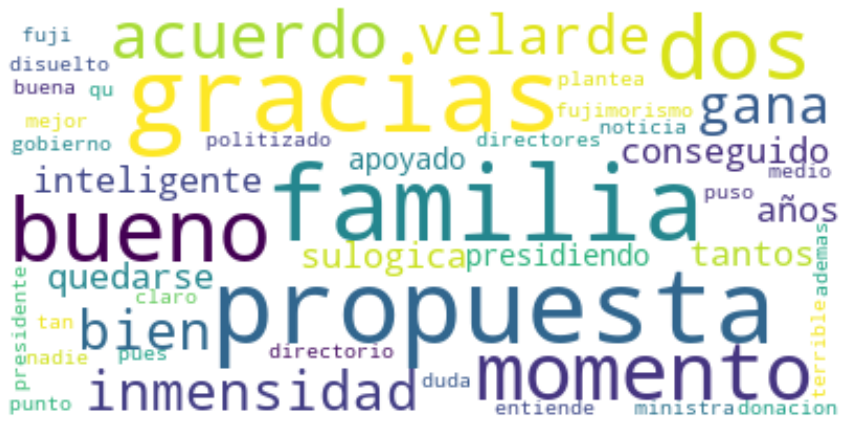

In [18]:
data["clean_stopwords"]=remove_stopwords(data["V_TEXTO_LIMPIO"]) #Eliminamos las palabras irrelevantes utilizando la función creada. 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)
wordcloud = WordCloud(max_words=100,min_font_size=10,max_font_size=50,background_color="white").generate(" ".join(data[data["I_POLARIDAD"]==1]["clean_stopwords"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

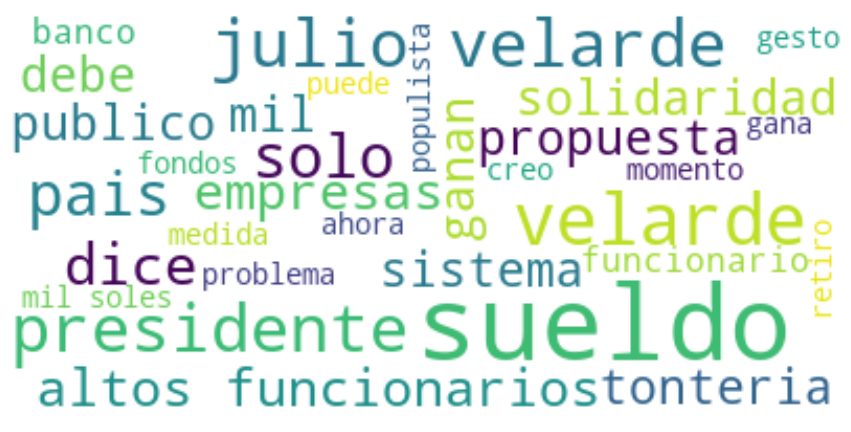

In [19]:
from wordcloud import WordCloud
plt.rcParams["figure.figsize"] = (15,15)
wordcloud = WordCloud(max_words=100,min_font_size=10,max_font_size=50,background_color="white").generate(" ".join(data[data["I_POLARIDAD"]==-1]["clean_stopwords"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [0]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Alertas_Negativas_Twitter")

In [22]:
!git init

Initialized empty Git repository in /content/drive/My Drive/Colab Notebooks/Alertas_Negativas_Twitter/.git/


In [0]:
!git add .